# Machine Learning II
## Project 2024/25 
#### Work assembled by Guilherme Santos (202208081), Luana Letra (202208587) and Vítor Ferreira (201109428).

## Table of contents <a name="contents"></a>

4. [CNN: A classifier based on a convolutional neural network](#cnn)
   - 4.1. [Data pre-processing and feature extraction](#cnn_data)
   - 4.2. [Model architecure](#cnn_model)
   - 4.3. [Training strategies](#cnn_training)
   - 4.4. [Performance evaluation](#cnn_performance)

In [6]:
import os
import soundata
import librosa
import soundfile as sf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

In [29]:
dataset = soundata.initialize('urbansound8k')

dataset.validate()  # validate that all the expected files are there

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 8732/8732 [00:20<00:00, 416.58it/s]
INFO: Success: the dataset is complete and all files are valid.
INFO: --------------------


({'metadata': {}, 'clips': {}}, {'metadata': {}, 'clips': {}})

In [8]:
# Load the metadata file 
metadata_path = '/Users/luana/sound_datasets/urbansound8k/metadata/UrbanSound8K.csv'    #change to the corresponding directory 
metadata = pd.read_csv(metadata_path)

## 4. CNN: A classifier based on a convolutional neural network <a name="cnn"></a>

Traditional machine learning models require manual feature extraction to be able to learn given patterns or information. However, CNNs receive raw data and are still able to extract relevant features.

### 4.1. Data pre-processing <a name="cnn_data"></a>
[[go back to the top]](#contents)

CNNs can be applied to 1D, 2D and 3D data. In the following machine learning process, the 1D waveforms are transformed to 2D Spectrograms. This way, it is possible to capture more relevant features as it reveals frequency information (pitch, harmonics,etc.) and temporal dynamics (rhythms,duration,etc.) than with the 1D waveforms as they only represent the raw audio as amplitude over time. 

**Fourier Transform**
- converts time-domain audio into a frequency represenation;
- converts signal from time to frequency domain, because every signal can be broken down to a set of sine and cosine waves;
- As we are working with non periodic signals, we need to capture them as they vary over time. Several Fourier Transformations are applied over overlapping windows of the signal **short-time Fourier Transform**, creating a **spectrogram**. 

**Log-Scaled Mel-Spectrogram**
- mimic human auditory processing by focusing on perceptually relevant frequency ranges;
- the frequency axis obtained by the fourtier transfrom is mapped into the mel scale ;
- makes the data more interpretable as well as for humans as for computers;

In [10]:
def create_spectrogram_save_as_png(y, sr, output_path):

    #Fourtier Transfrom 
    n_fft = 1024 #window size
    hop_length = 512
    n_mels = 60          

    ms = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=n_fft, hop_length= hop_length)
    log_ms = librosa.power_to_db(ms, ref=np.max)

    # Plot and save the spectrogram as a PNG
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(log_ms, sr=sr, hop_length=hop_length, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel Spectrogram')
    plt.tight_layout()
    plt.savefig(output_path)
    plt.close()


In [11]:
from keras.preprocessing import image

#to open images and labels 
def load_images_from_path(path):

    #order of images and labels match 
    images = []
    labels = []

    for file in os.listdir(path):
        images.append(image.img_to_array(image.load_img(os.path.join(path, file), target_size=(224, 224, 3))))
        
        #extract the class from the filename
        filename = os.path.splitext(file)[0]  # Remove file extension
        label = filename.split('_')[-1]  # Extract label after the underscore
        labels.append(int(label))
        
    return images, labels

In [12]:
import librosa
def prepare_folddata(metadata, image_dir, audio_dir, fold, target_duration=4.0):
    """Prepare features and labels for a specific fold."""
  
    # Get files for this fold
    fold_data = metadata[metadata['fold'] == fold]
    
    for idx, row in fold_data.iterrows():
        #load a file 
        file_path = os.path.join(audio_dir, f'fold{fold}', row['slice_file_name'])    #file_path including .wav
        try:
            # Load and preprocess audio
            y, sr = librosa.load(file_path, sr=22050, mono=True)

            #debug: test if y is ndarray
            if not isinstance(y, np.ndarray):
                print(f"Error: {file_path} did not load as a numpy array.")
                continue
            
            #print(f"Loaded {file_path} with shape: {y.shape}, sample rate: {sr}")
            
            # Pad audio if shorter than target duration
            target_samples = int(target_duration * sr)
            if len(y) < target_samples:
                padding = target_samples - len(y)
                y = np.pad(y, (0, padding), mode='constant')

            #adds subdirectory named foldX in image_cnn to save 
            output_path = os.path.join(image_dir, f'fold{fold}', f"{row['slice_file_name'].replace('.wav', '')}_{row['classID']}.png")
            create_spectrogram_save_as_png(y, sr, output_path)
            
        except Exception as e:
            print(f"Error processing {file_path}: {str(e)}")
    
    

In [19]:
# Prepare data for all folds
audio_dir = '/Users/luana/sound_datasets/urbansound8k/audio'
image_dir = 'images_cnn'

# Create directory if it doesn't exist
os.makedirs(image_dir, exist_ok=True)

# Process each fold and save separately
for fold in range(1, 11):
    print(f"Processing fold {fold}")
    path = os.path.join(image_dir, f"fold{fold}")
    os.makedirs(path, exist_ok=True)
    fold_data = prepare_folddata(metadata,image_dir, audio_dir, fold)   #remember matadata is the .csv 

print("Image creation complete. Images saved in 'image_cnn' directory")

Processing fold 1
Processing fold 2
Processing fold 3
Processing fold 4
Processing fold 5
Processing fold 6
Processing fold 7
Processing fold 8
Processing fold 9
Processing fold 10
Image creation complete. Images saved in 'image_cnn' directory


### 4.2. Model Architecture <a name="cnn_model"></a>
[[go back to the top]](#contents)

To optimize our models architecture, we conducted several experiments with different settings and analysed the accuracy and loss over the validation set of the first fold. Using only one fold allows us to significantly reduce the computational complexity associated with hyperparameter tuning. This approach enables us to explore a wider range of different setting for our model, migitating high costs of training the model over multiple folds. Furthermore, by using the same fold for every set of different hyperparameters, we ensures that any observed changes in the performance are based on the different configurations rather than variability in the validation data.

In [32]:
# implementation of the best model resulting from the hyperparameter tuning 

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout, Input
from tensorflow.keras.optimizers import SGD
from sklearn.metrics import confusion_matrix


def cnn_model(num_classes = 10, height = 224, width = 224, channels = 3):
    "First implementation: 4 convolutional layers filters(16->32->64->128)"
    model = Sequential([
        
            Input(shape=(height, width, channels)),
        
            Conv2D(16, (3, 3), activation='relu'),  # Set height, width, and channels based on your input
            BatchNormalization(),
            MaxPooling2D((2, 2)),
        
            Conv2D(32, (3, 3), activation='relu'),  # Set height, width, and channels based on your input
            BatchNormalization(),
            MaxPooling2D((2, 2)),
            
            Conv2D(64, (3, 3), activation='relu'),
            BatchNormalization(),
            MaxPooling2D((2, 2)),
        
            Conv2D(128, (3, 3), activation='relu'),
            BatchNormalization(),
            MaxPooling2D((2, 2)),
        
            Flatten(),
            Dense(128, activation='relu'),
            BatchNormalization(),
            Dropout(0.7),
            
            Dense(num_classes, activation='softmax')
        ])
    # Compile the model
    model.compile(optimizer=SGD(learning_rate=0.01), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model


We have tested three different configurations for the number of layers and with increasing number of filters, starting with 16 and doubling with each layer.

Each model consists of: 

**Input layer**: which receives an input image of shape (224x224x3)

**Convolutional blocks**: 
- consists of convolutional layer itself
- Batch Normalization to stablizie the network during training, it normalizes the activations of each layer so that they have a stable distribution
- MaxPooling2D to downsample feature maps witha 2x2 filter

**Fully Connected Layer**
- Flattens 3D output from the convolutional layers into a 1D vector
- Dense layer that is a fully connected layer with 128 neurons and ReLU activation
- Batch Normalization normalized the activations of the dense layer
- Dropout randomly drops 70% of the neurons to prevent overfitting

Furthermore, they all used the Stochastic Gradient Descent optimizer and use sparse categorical crossentropy to calculate the loss of each model.

**Model 1**
- 3 convolutional layers
- increasing filter number with each layer, 16->32->64
  

**Model 2**
- 4 convolutional layers
- increasing filter number with each layer, 16->32->64->128

**Model 3**
- 2 convolutional layers
- increasing fliter number, 16->32

All models tend to overfit on the training data, as indicated by the training accuracies which are all around 95% meanwhile the validation accuracies are between 50% and 57%. Additionally, the validation loss is significantly higher than the training loss further supporting the observation of overfitting. As all 3 models have the tendency to overfit, we chose to further develop the model that has the lowest validation loss. As the accuracies for the first and second modelvery close and the validation loss for the second model slightlt less that for the first model, meaning it generalizes slightly better to unseen data.

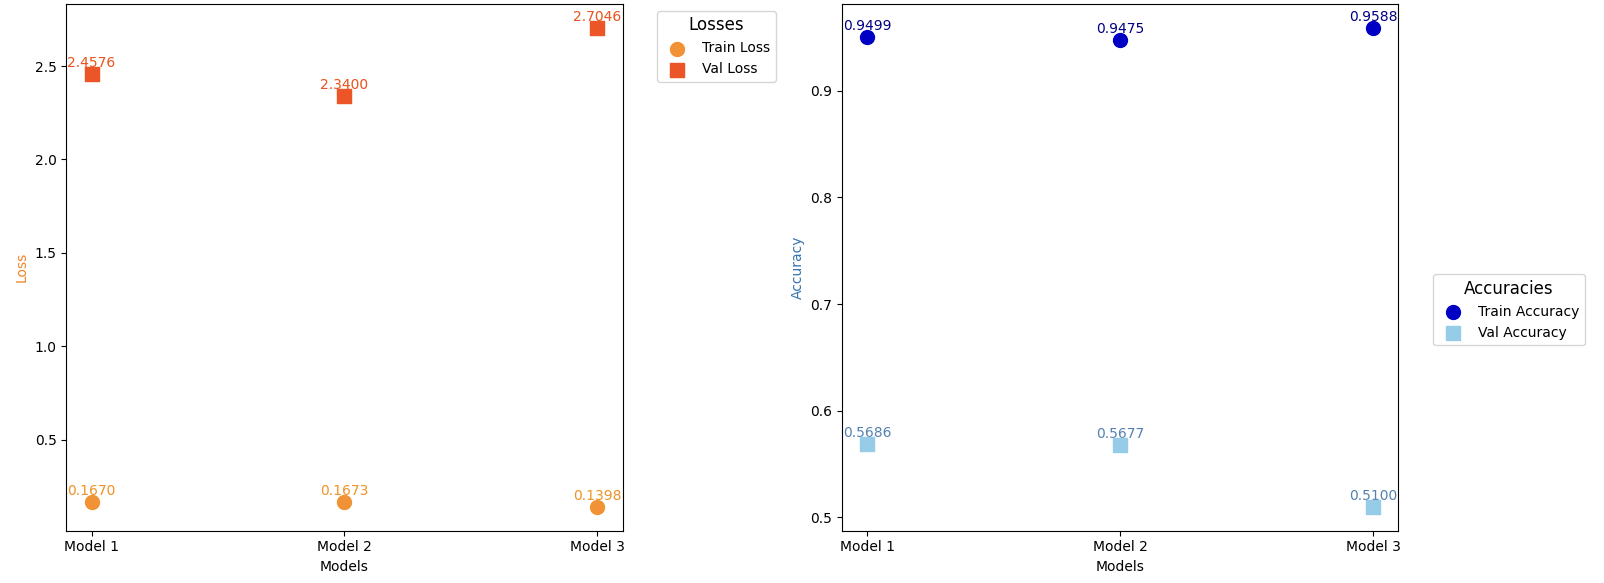

### 4.3. Training Strategies <a name="cnn_training"></a>
[[go back to the top]](#contents)

With the intention to increase our models ability to perfrom well on unseen data, we have tested several **optimizers** (Adam, SGD, RMSprop, Adelta). 
We can see that from all the tested optimizers **Stochastic Gradient Descent** is the one who addresses our overfitting concern and therefore contributes to a more stable generalization on unseen data. 

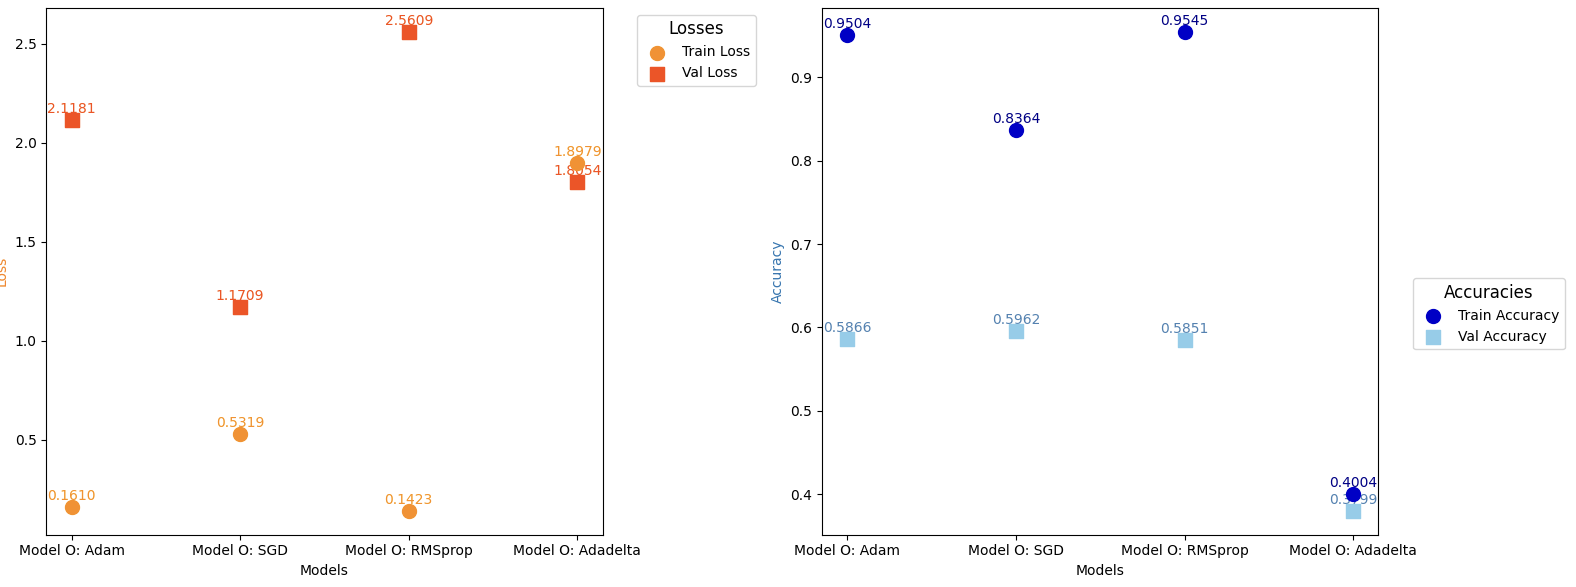

Afterwards, we experimented with different **learning rates** (0.01, 0.001, 0.0001, 0.05). We can observe that the model with learning rate 0.0001 tends to underfit as both validation and training accuracies are relatively low therefore is not interesting for us to develop further. All the other models keep the tendency to overfit our data.

The model that performs the best is the model with learning rate 0.01. Despite showing signs of overfitting it is still the one performing best on the validation set. We will base further hyperparameter tuning on the model with **learning rate 0.01**.

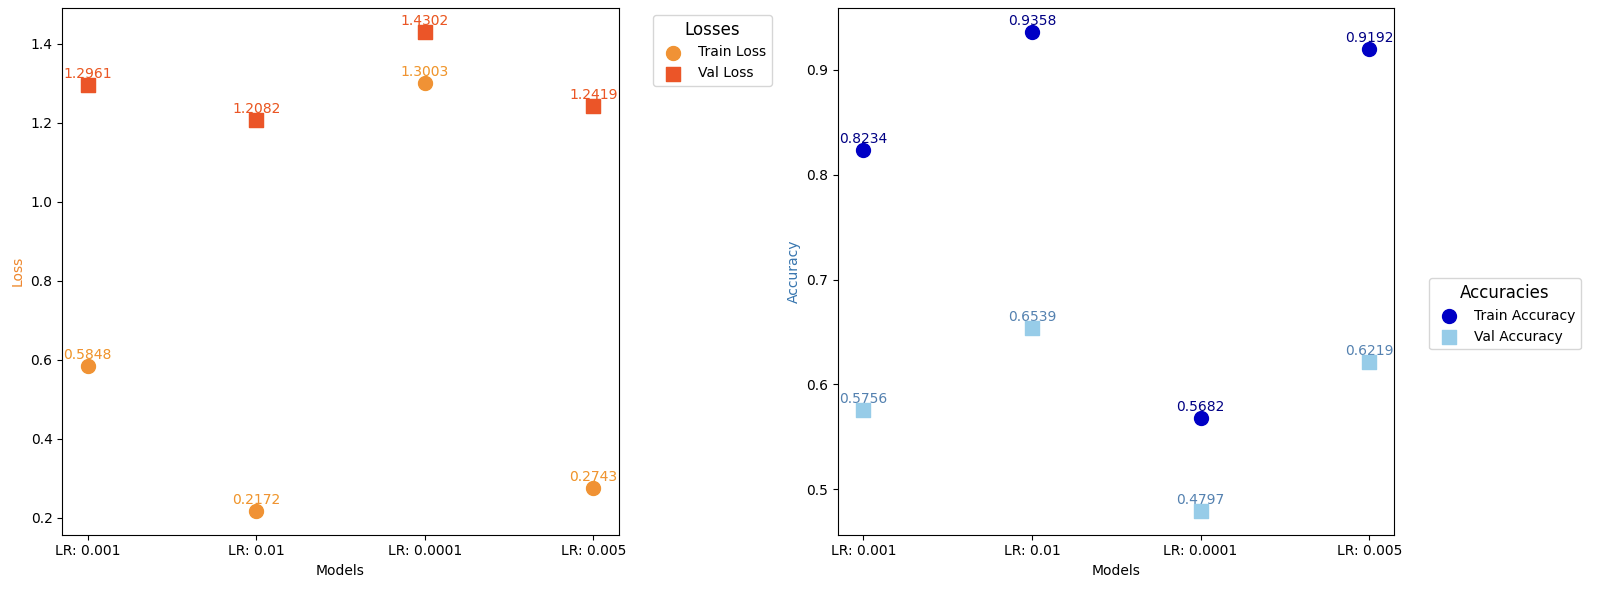

After experimenting with different **Dropout rates** we can see, that overall that the best performing rate is 0.7. It shows the lowest validation loss and the highest validation accuracy. It still shows tendencies to overfit but given the other tested models, it promises the better results when performing on unseen data.

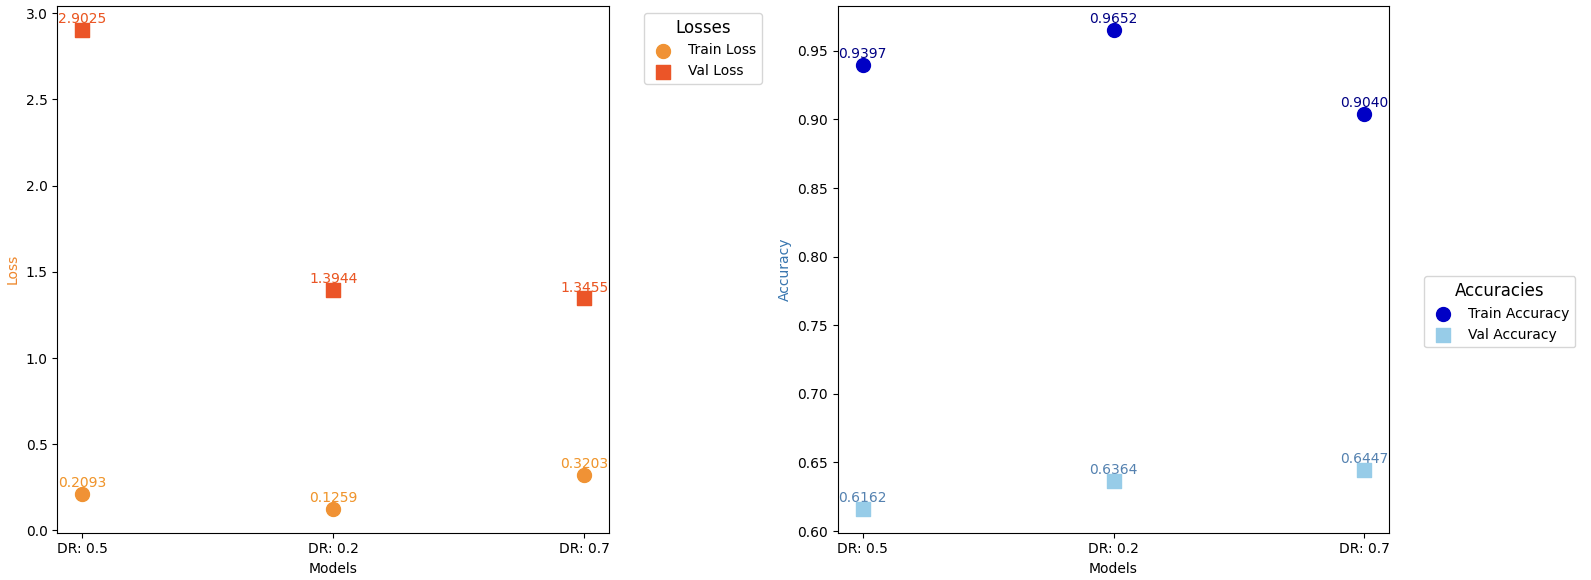

We also conducted tests with different **Training epochs**. The problem of overfitting still continues present in our tested models, evidenced by training accuracies much higher than  validation accuracies and low training loss and relatively high validation losses. Among all models, we tend to see the most potential using a model with **50 epochs** as it provides a good balance between accuracy and loss. Its archieves an accuracy close to the highest measured acccuracy and it has the second lowest validation loss, which suggests better generalization to unseen data. This makes it the most suitable choice to mitigate overfitting in this scenario.

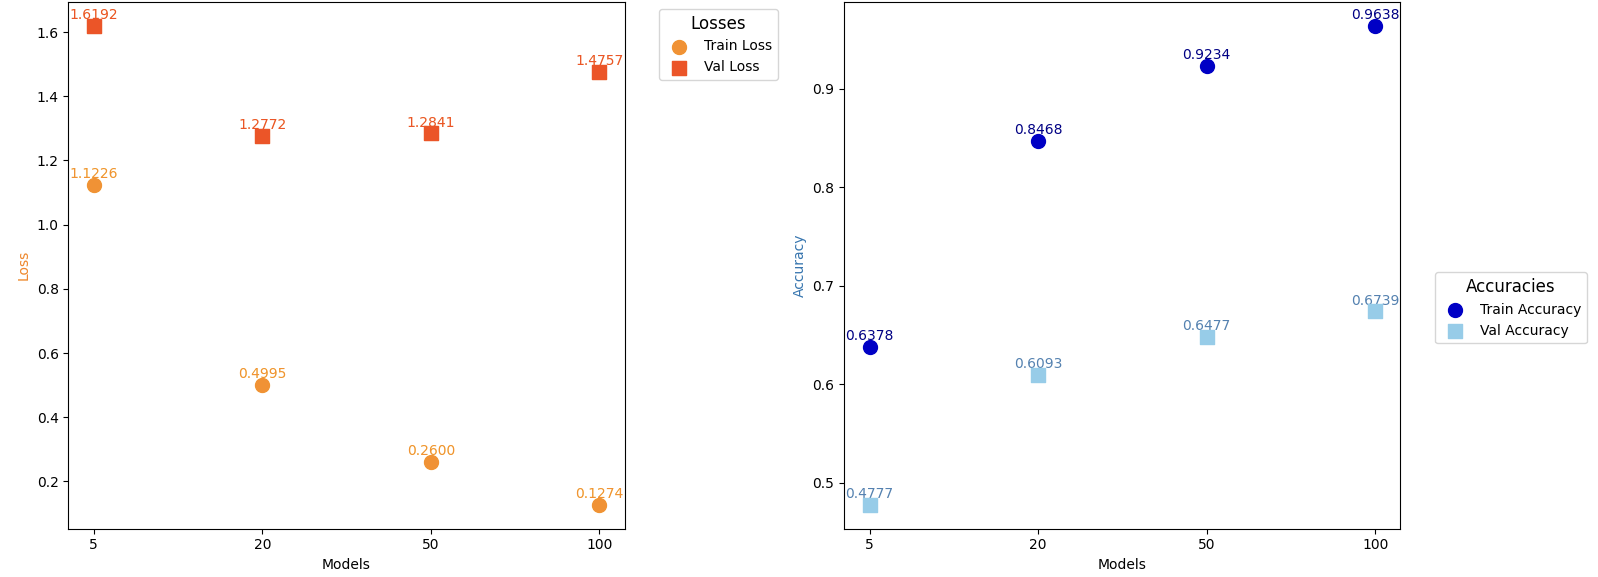

In [31]:
# Clear previous session
tf.keras.backend.clear_session()

model = cnn_model()  

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 109, 109, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 52, 52, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     2,359,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,459,626 (9.38 MB)

 Trainable params: 2,458,890 (9.38 MB)

 Non-trainable params: 736 (2.88 KB)

### 4.4. Performance Evaluation <a name="cnn_performance"></a>
[[go back to the top]](#contents)

In [19]:
def load_and_prepare_data():
    "loads the images and their according class"
    all_images = []
    all_labels = []
    print("Loading images..")
    for fold in range(1,11):
        path = os.path.join('images_cnn', f"fold{fold}")
        images, labels = load_images_from_path(path)
        all_images.append( images)
        all_labels.append(labels)

    return all_images, all_labels
        
        

In [28]:
def evaluate_model(model_function, images, lables, model_name = 'Model', num_folds=10, epochs=50, batch_size=32, seed=42):


    tf.keras.backend.clear_session()

    # Initialize metrics storage
    accuracies = []
    histories = [] 
    class_names = ["AC", "CH", "CP", "DB", "DR", "EI", "GS", "JA", "SI", "SM"]
    cumulative_conf_matrix = np.zeros((10, 10))

    # Cross-validation loop
    for i in range(num_folds):  
        
        print(f"\nTraining {model_name} - Fold {i+1}/{num_folds}")
        # Clear previous session and set random seeds
        tf.keras.backend.clear_session()
        tf.random.set_seed(seed)

        early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
        )
        
        # Define train, validation and test sets for this fold
        test_fold = i
        val_fold = (i + 1) % num_folds  # Next fold is validation
        train_folds = [f for f in range(num_folds) if f not in [test_fold, val_fold]]
        
        # Combine training data (8 folds)
        train_images = np.concatenate([images[f] for f in train_folds])
        train_labels = np.concatenate([labels[f] for f in train_folds])
        
        # Get validation data (1 fold)
        val_images = np.array(images[val_fold])
        val_labels = np.array(labels[val_fold])
        
        # Get test data (1 fold)
        test_images = np.array(images[test_fold])
        test_labels = np.array(labels[test_fold])
        
        
        # Create and train model
        model = cnn_model()
        
        # Train using validation data instead of validation_split
        history = model.fit(
            train_images, train_labels,
            epochs=epochs,
            batch_size=batch_size,
            validation_data=(val_images, val_labels),  # Use explicit validation fold
            callbacks=[early_stopping],
            verbose=1
        )
        histories.append(history.history)
        
        # Evaluate on test fold
        predictions = np.argmax(model.predict(test_images), axis=1)
        
        # Compute metrics
        fold_conf_matrix = confusion_matrix(test_labels, predictions, labels=range(10))
        cumulative_conf_matrix += fold_conf_matrix
        
        # Calculate and store accuracy
        test_loss, test_accuracy = model.evaluate(test_images, test_labels, verbose=0)
        accuracies.append(test_accuracy)
        
        print(f"Fold {i+1} Accuracy: {test_accuracy:.4f}")

    # Calculate final metrics
    mean_accuracy = np.mean(accuracies)
    std_accuracy = np.std(accuracies)
        
    print(f"\n{model_name} Final Results:\n")
    print(f"Mean accuracy: {mean_accuracy:.4f}")
    print(f"Std accuracy: {std_accuracy:.4f}")
        
    # Print raw numbers matrix
    print("\nRaw Counts Confusion Matrix:")
    plt.figure(figsize=(12, 10))
    sns.heatmap(cumulative_conf_matrix, annot=True, fmt="g", cmap="Blues",
        xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.title("Cumulative Confusion Matrix (Raw Counts)")
    plt.tight_layout()
    plt.show()
    
    # Create normalized confusion matrix (percentages by row)
    row_sums = cumulative_conf_matrix.sum(axis=1)
    normalized_conf_matrix = (cumulative_conf_matrix.T / row_sums).T * 100
    
    # Plot normalized confusion matrix
    plt.figure(figsize=(12, 10))
    sns.heatmap(normalized_conf_matrix, annot=True, fmt=".1f", cmap="Blues",
        xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.title("Normalized Confusion Matrix (% by row)")
    plt.tight_layout()
    plt.show()
    
    # Analyze confusion patterns
    print("\nAnalyzing Confusion Patterns:")
        
    def analyze_confusions(normalized_conf_matrix, class_names, threshold=10):
        """Analyze which classes are commonly confused with each other"""
        print(f"\nMost Common Confusions (>{threshold}%):")
        for i in range(len(class_names)):
            for j in range(len(class_names)):
                if i != j and normalized_conf_matrix[i][j] > threshold:
                    print(f"{class_names[i]} confused with {class_names[j]}: {normalized_conf_matrix[i][j]:.1f}%")
        
    # Create confusion matrix without diagonal
    confusion_no_diagonal = normalized_conf_matrix.copy()
    np.fill_diagonal(confusion_no_diagonal, 0)  # Set diagonal to 0 to focus on confusions
        
    # Plot heatmap without diagonal
    plt.figure(figsize=(12, 10))
    sns.heatmap(confusion_no_diagonal, annot=True, fmt=".1f", cmap="Blues",
        xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.title(f"{model_name} - Confusion Matrix (% by row, diagonal removed)")
    plt.tight_layout()
    plt.show()
        
    # Run confusion analysis
    analyze_confusions(normalized_conf_matrix, class_names, threshold=10)
        
    # Print per-class metrics
    print("\nPer-class Performance:")
    for i, class_name in enumerate(class_names):
        true_positives = cumulative_conf_matrix[i, i]
        total_actual = np.sum(cumulative_conf_matrix[i, :])
        accuracy = true_positives / total_actual if total_actual > 0 else 0
        print(f"{class_name}: Accuracy = {accuracy:.4f} (Total samples: {total_actual})")
        
    return {
        'mean_accuracy': mean_accuracy,
        'std_accuracy': std_accuracy,
        'histories': histories,
        'accuracies': accuracies,
        'confusion_matrix': cumulative_conf_matrix,
        'normalized_confusion_matrix': normalized_conf_matrix,
        'confusion_no_diagonal': confusion_no_diagonal
    }


Loading images..

Training Model Concolutional Neural Network - Fold 1/10
Epoch 1/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 70s 320ms/step - accuracy: 0.2801 - loss: 2.3363 - val_accuracy: 0.2128 - val_loss: 2.7118
Epoch 2/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 70s 319ms/step - accuracy: 0.5290 - loss: 1.4165 - val_accuracy: 0.4651 - val_loss: 1.4388
Epoch 3/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 70s 320ms/step - accuracy: 0.6562 - loss: 1.0551 - val_accuracy: 0.4966 - val_loss: 1.2620
Epoch 4/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 69s 318ms/step - accuracy: 0.7251 - loss: 0.8857 - val_accuracy: 0.5845 - val_loss: 1.0677
Epoch 5/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 70s 321ms/step - accuracy: 0.7858 - loss: 0.7174 - val_accuracy: 0.5203 - val_loss: 1.2967
Epoch 6/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 69s 318ms/step - accuracy: 0.8225 - loss: 0.6184 - val_accuracy: 0.6182 - val_loss: 1.0281
Epoch 7/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 70s 321ms/step - accuracy: 0.8408 - loss: 0.5330 - val_accuracy: 0.5146 - val_loss: 1.4714
Epoch 8/5

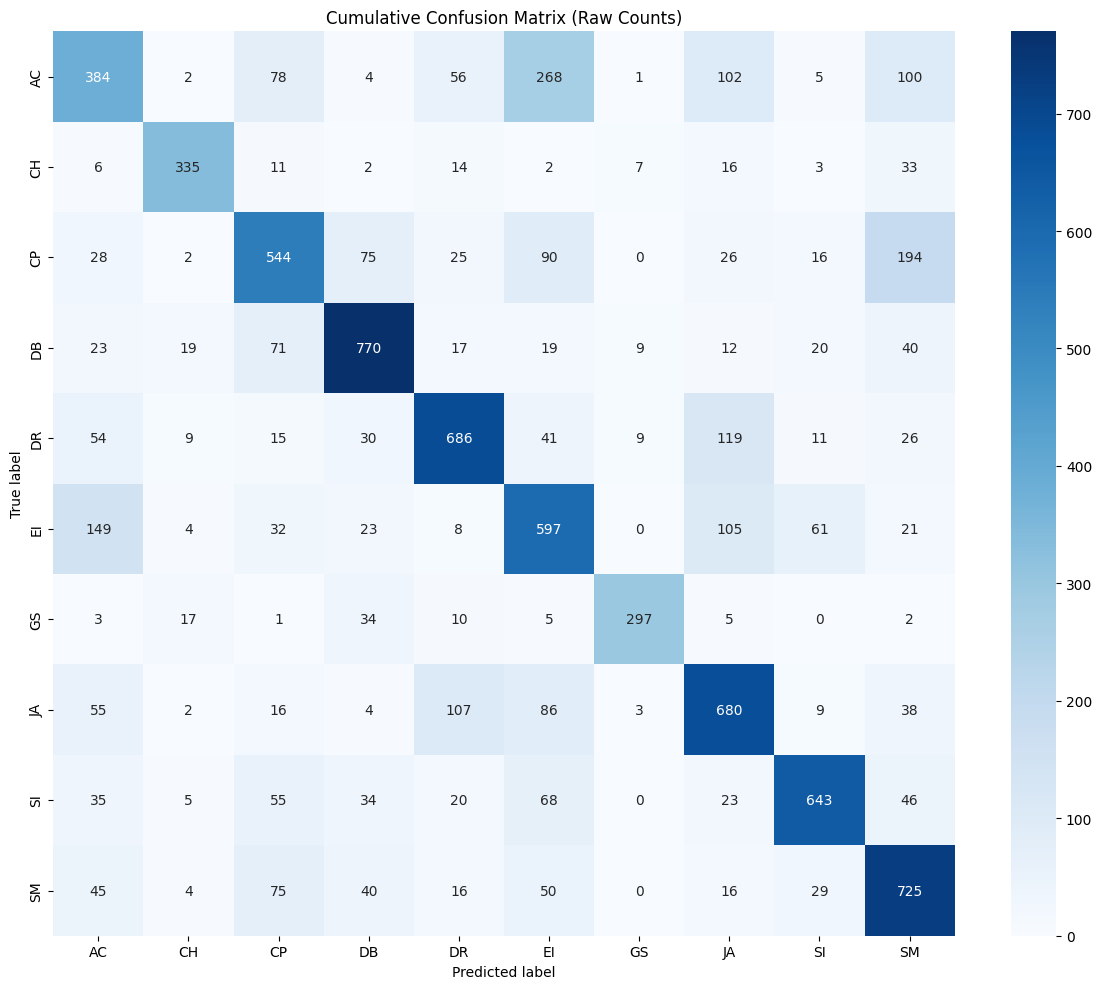

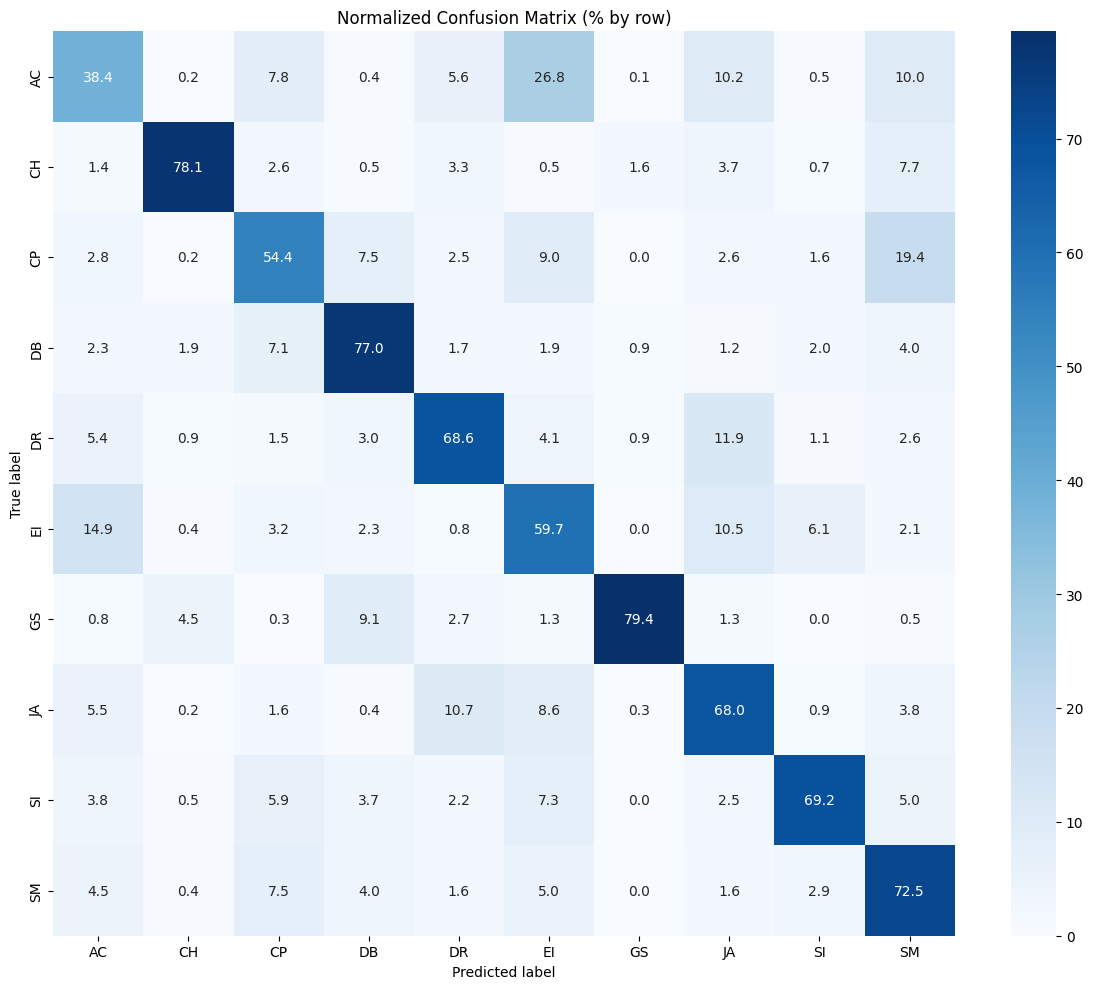


Analyzing Confusion Patterns:


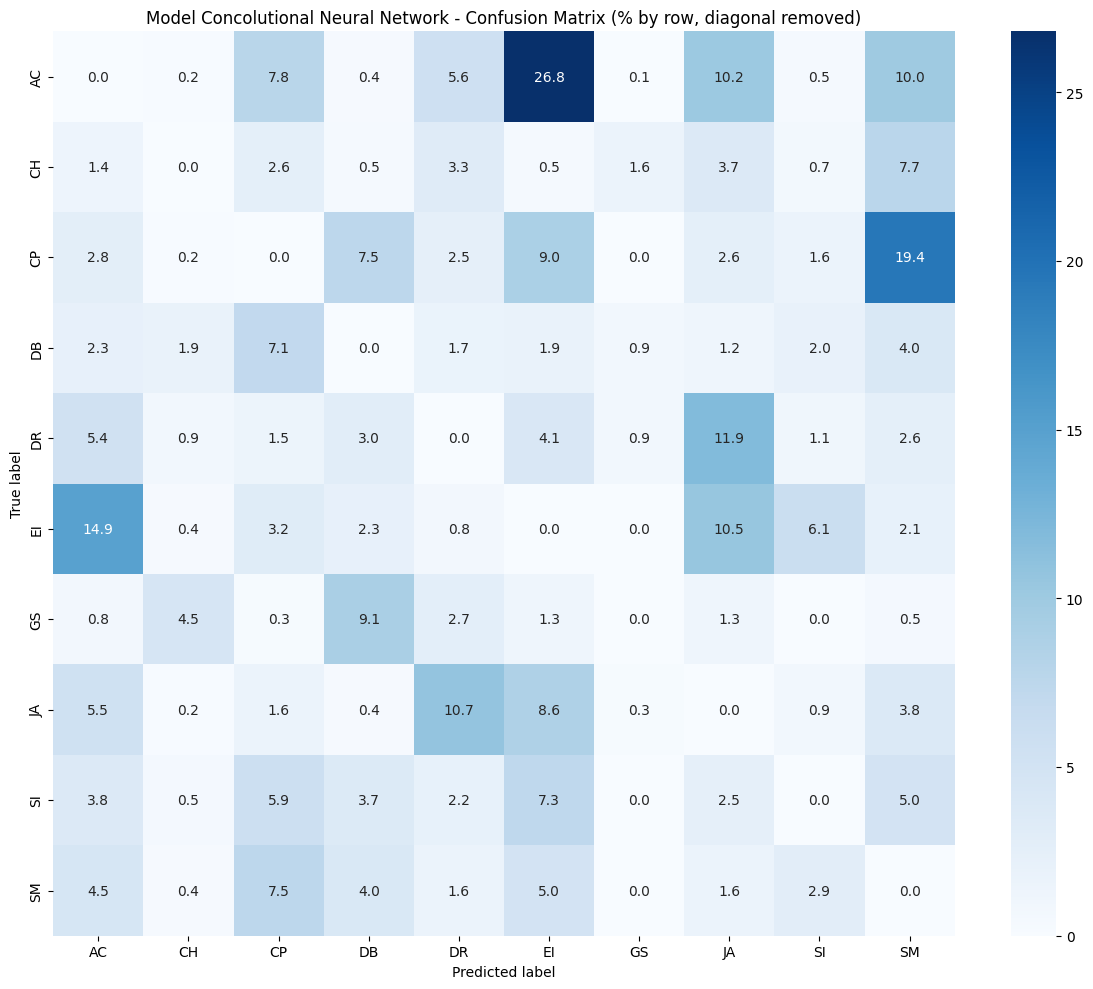


Most Common Confusions (>10%):
AC confused with EI: 26.8%
AC confused with JA: 10.2%
CP confused with SM: 19.4%
DR confused with JA: 11.9%
EI confused with AC: 14.9%
EI confused with JA: 10.5%
JA confused with DR: 10.7%

Per-class Performance:
AC: Accuracy = 0.3840 (Total samples: 1000.0)
CH: Accuracy = 0.7809 (Total samples: 429.0)
CP: Accuracy = 0.5440 (Total samples: 1000.0)
DB: Accuracy = 0.7700 (Total samples: 1000.0)
DR: Accuracy = 0.6860 (Total samples: 1000.0)
EI: Accuracy = 0.5970 (Total samples: 1000.0)
GS: Accuracy = 0.7941 (Total samples: 374.0)
JA: Accuracy = 0.6800 (Total samples: 1000.0)
SI: Accuracy = 0.6921 (Total samples: 929.0)
SM: Accuracy = 0.7250 (Total samples: 1000.0)


In [25]:
images, labels = load_and_prepare_data()
result = evaluate_model(cnn_model, images, labels, "Model Convolutional Neural Network")

**Overall Performance:**
- The model achieved varying accuracies across different sound classes, with an overall mean accuracy around 65%


**Best Performing Classes:**
- Gun Shot (GS): 79,41% accuracy
- Car Honk (CH): 78,09% accuracy
- Dog Bark (DB): 77% accuracy

**Challenging Classes**:
- Air Conditioner (AC) 38,40% accuracy
- Children playing (CP) 54,40% accuracy
- Engine Idling (EI) 59,70 %

**Common Confusion Patterns**:
- Air Conditioning (AC) with Engine Idling (EI): 26,8% confusion rate
- Children Playing (CP) with Street Music (SM): 19.4% confusion rate
- Engine Idling (EI) with Air Conditioning (AC): 14.9% confusion rate

**Notable Pattern**:
- Environmental Sounds (AC, CP, EI, SM) tend to be confused with each other, appearing to have overlapping features
- (JA) and (DR) are confused 10.7% and vice versa 11.9%, indicating that they may share temporal or tonal features

These results indicate that while the model performs well for distinctive sounds like gunshots, sirens and car horns, it **struggles with environmental similar sounds**.

To address this, we could introduce **data augmentation** or **fine-tuning** to the model.